## dataset functions

In [1]:
# dataset = "exp_density"
# from exp_density_polynomial import *
# dataset = "cvar"
# from cvar import *
dataset = "energy"
from energy import *
# dataset = "kelly"
# from kelly import *
# dataset = "news_vendor"
# from news_vendor import *

device = cpu


## osmm

In [2]:
from osmm import OSMM

## generate random data

In [3]:
W = generate_random_data()
W_validation = generate_random_data()
init_val = get_initial_val()

## solve

In [4]:
osmm_prob = OSMM(f_torch=my_objf_torch, g_cvxpy=get_cvxpy_description)
osmm_prob.solve(W, init_val, solver="MOSEK", eps_gap_abs=1e-4)#, W_validate=W_validation, stop_early=False)

Hutchinson #iters 34 rel. incr. 0.00019123516270188866 est. tr. 25.572076502968283
lam_0 =  0.8249056936441381 , Hutchinson time cost =  0.03423285484313965


/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


iter= 10 objf_k+1= 7.197996616363525 L_k+1= 6.780388619270668 lam_k+1= 0.001753728285178239 tk= 0.5 mu_k+1 0.2030043136000001 ||G_k+1||_F= 2.31432509684047 tau_k+1 0.008638872022363953
iter= 20 objf_k+1= 7.1346917152404785 L_k+1= 7.082320100528042 lam_k+1= 0.0010369149765238198 tk= 1.0 mu_k+1 0.10713185553479643 ||G_k+1||_F= 2.44967294001207 tau_k+1 0.009678866956495773
iter= 30 objf_k+1= 7.130923748016357 L_k+1= 7.1281617048801 lam_k+1= 0.002305306381124846 tk= 1.0 mu_k+1 0.04111774507034097 ||G_k+1||_F= 5.8958377863161875 tau_k+1 0.056065972907344774
iter= 40 objf_k+1= 7.130883693695068 L_k+1= 7.12860300436991 lam_k+1= 0.002081727128202148 tk= 1.0 mu_k+1 0.01147723447032849 ||G_k+1||_F= 10.6044736826322 tau_k+1 0.1813788098155467
iter= 50 objf_k+1= 7.130843639373779 L_k+1= 7.129966968549573 lam_k+1= 0.002168708262905767 tk= 0.25 mu_k+1 0.008328241551560549 ||G_k+1||_F= 12.706319029215416 tau_k+1 0.2604041020519384
iter= 60 objf_k+1= 7.130839824676514 L_k+1= 7.129966968549573 lam_k+1=

## get results

In [5]:
x_soln = osmm_prob.method_results["soln"]
Xs = osmm_prob.method_results["var_iters"]

In [6]:
max_num_rounds = len(osmm_prob.method_results["objf_iters"])
iters_taken = osmm_prob.method_results["iters_taken"]

In [7]:
objfs = np.array(osmm_prob.method_results["objf_iters"])
for i in range(1, iters_taken):
    objfs[i] = np.min(osmm_prob.method_results["objf_iters"][0:i + 1])
objfs[iters_taken::] = objfs[iters_taken]
objf_min = np.min(objfs[0:iters_taken + 1])

In [8]:
print(objfs[0:3])

[16.03293991 11.44960594  9.46342564]


In [9]:
objfs_val = np.array(osmm_prob.method_results["objf_validate_iters"])
objfs_val[iters_taken::] = objfs_val[iters_taken]

In [10]:
lower_bounds = np.array(osmm_prob.method_results["lower_bound_iters"])
lower_bounds[iters_taken::] = lower_bounds[iters_taken]

In [11]:
opt_res_norms = np.array(osmm_prob.method_results["opt_res_iters"])
start_idx = 1
for i in range(start_idx, iters_taken):
    opt_res_norms[i] = np.min(osmm_prob.method_results["opt_res_iters"][start_idx:i + 1])
opt_res_norms[iters_taken::] = opt_res_norms[iters_taken]

## plots

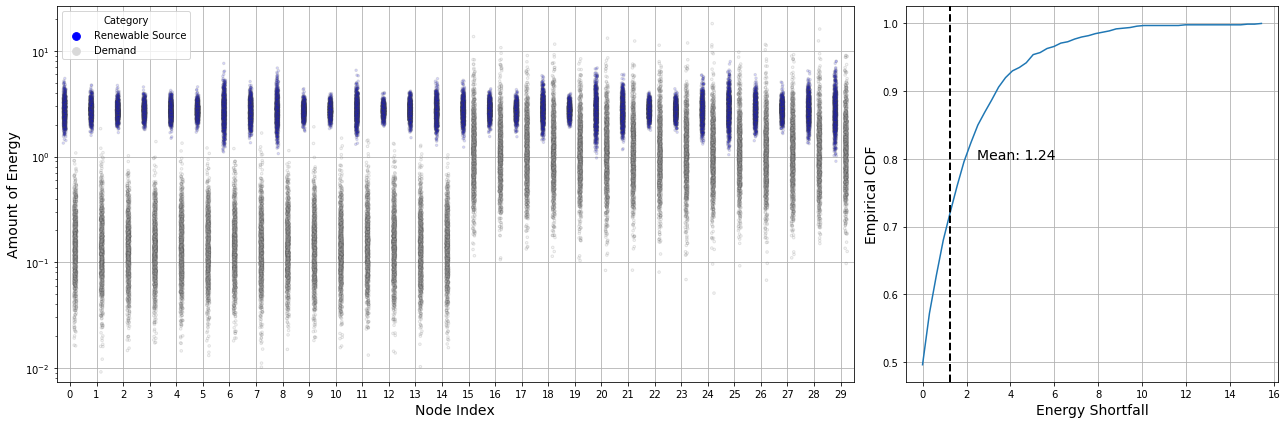

In [12]:
if dataset == "exp_density":
    my_plot_exp_density_one_result(Xs, objfs, iters_taken)
else:
    my_plot_one_result(W, x_soln, is_save_fig=False, figname="cvar_pnt9_result.pdf")

In [13]:
linewidth = 2
fontsize = 16
font = {'family': 'serif',
        'size': fontsize,
        }

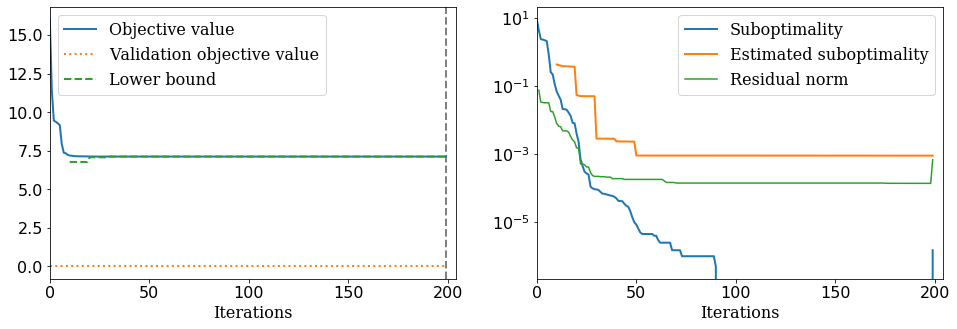

In [14]:
fig = plt.figure(tight_layout=False, figsize=(16, 5))
gs = gridspec.GridSpec(1, 2)
plt.rcParams.update({'font.size': fontsize})

plot1 = fig.add_subplot(gs[0, 0])
rounds = range(0, max_num_rounds)
if osmm_prob.method_results["iters_taken"] < max_num_rounds:
    plot1.axvline(osmm_prob.method_results["iters_taken"], color='gray', linestyle='dashed', linewidth=linewidth)
##objf
plot1.plot(np.array(rounds), objfs, linewidth=linewidth, label="Objective value")
##objf_validation
plot1.plot(np.array(rounds), objfs_val, ':', linewidth=linewidth, label="Validation objective value")
##l_k
plot1.plot(np.array(rounds), lower_bounds, '--', linewidth=linewidth, label="Lower bound")

plot1.set_xlabel("Iterations", fontdict=font)
plot1.legend(prop=font)

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
##subopt
plot2.plot(np.array(rounds), objfs - objf_min, linewidth=linewidth, label="Suboptimality")
## gaps
gaps = objfs - lower_bounds
plot2.plot(rounds, gaps, linewidth=linewidth, label="Estimated suboptimality")
## residual norm
plot2.plot(rounds[start_idx::], opt_res_norms[start_idx::] / n, label="Residual norm", color='#2ca02c')

plot2.set_xlabel("Iterations", fontdict=font)
plot2.set_yscale("log")
plot2.legend(prop=font)

plot_iter_lim = iters_taken + 5
ylim = None
if plot_iter_lim is not None:
    plot1.set_xlim([0, plot_iter_lim])
    plot2.set_xlim([0, plot_iter_lim])
if ylim is not None:
    plot2.set_ylim([ylim[0], ylim[1]])

In [15]:
print(osmm_prob.method_results["soln_additional_vars"])

[array([ 0.0418709 ,  0.09875674, -0.00594856,  0.09999999, -0.07803368,
        0.09999999,  0.09999999, -0.05344981,  0.09999999,  0.09999999,
        0.09999999,  0.09999999,  0.01881629,  0.09999999,  0.02008025,
       -0.07549718,  0.09999999, -0.09829431,  0.09999999,  0.09999999,
        0.09999999,  0.04421235,  0.09999999,  0.09999999, -0.07161911,
        0.09999999, -0.09650513,  0.09999999,  0.09999999, -0.05503953,
       -0.07572896,  0.09999999,  0.09999999,  0.09999999,  0.00546613,
       -0.01389056,  0.09999999, -0.01306219,  0.09999999,  0.07158398,
       -0.09709136,  0.06919014,  0.00051094,  0.09999999,  0.09999999,
        0.09999999,  0.07569139,  0.09835719,  0.09999999,  0.09999999,
       -0.03414388, -0.08173547, -0.03044909,  0.09818092,  0.09999999,
        0.09999999,  0.09999999,  0.06048529, -0.02997838,  0.09999999,
       -0.0987578 ,  0.09828543,  0.09999999,  0.04897253,  0.09843837,
       -0.07551568,  0.06695615, -0.03900309,  0.09999999,  0.0